# 📘 Watt Wise – Week 1 EDA Code and Markdown Reference

In [1]:
import pandas as pd
import matplotlib as plt

In [2]:
df = pd.read_csv("local_data/Energy_consumption.csv")

In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # If not already datetime
df.set_index('Timestamp', inplace=True)

## Line Plot of Energy Consumption Over Time

<Axes: title={'center': 'Energy Consumption Over Time'}, xlabel='Timestamp'>

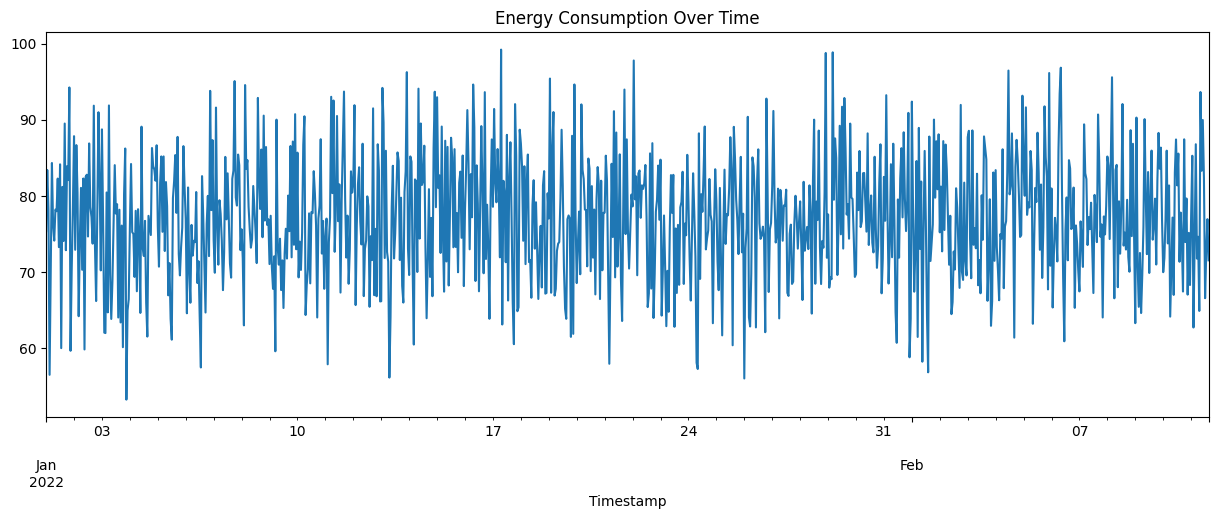

In [4]:
df['EnergyConsumption'].plot(figsize=(15,5), title='Energy Consumption Over Time')

### **Line Plot of Energy Consumption Over Time**

* **What it shows:** The raw energy consumption fluctuates significantly from hour to hour, indicating high-frequency variation or noise.
* **Interpretation:** There’s no obvious long-term upward or downward trend, but the signal is quite "noisy." This suggests the need for smoothing or decomposition before forecasting.
* **Action:** Indexing by timestamp enables resampling, time-based slicing, and rolling windows.

### Smooth the Line with a Rolling Mean

<Axes: title={'center': '24-Hour Rolling Average of Energy Consumption'}, xlabel='Timestamp'>

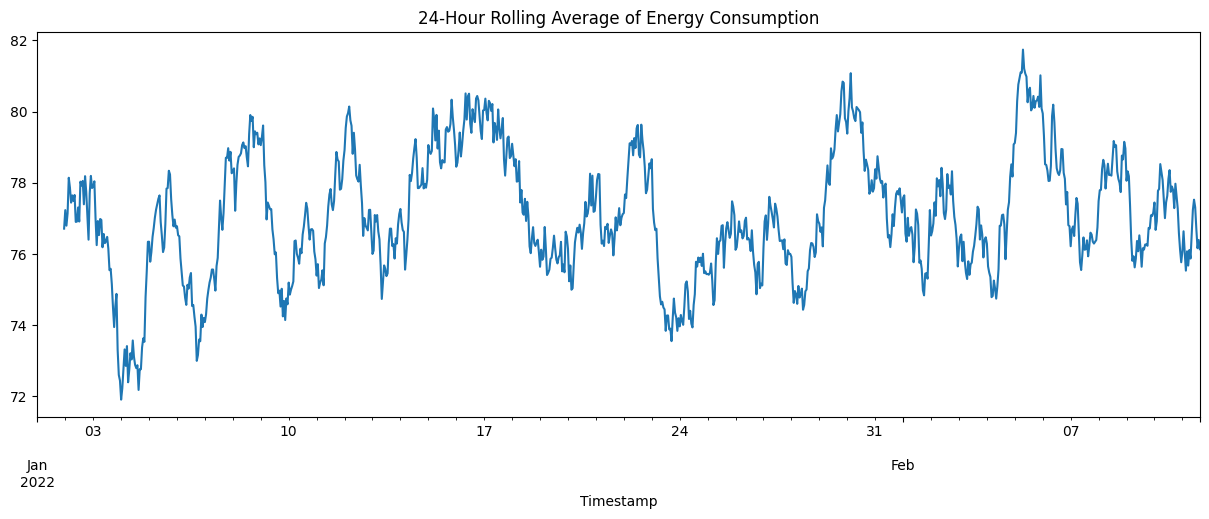

In [5]:
df['EnergyConsumption'].rolling(window=24).mean().plot(figsize=(15, 5), title='24-Hour Rolling Average of Energy Consumption')

### **24-Hour Rolling Mean**

* **What it shows:** A smoothed version of the previous line plot, averaging consumption over daily intervals.
* **Interpretation:** Now some patterns emerge. You can spot cycles of higher and lower usage—perhaps tied to weekday/weekend or occupancy patterns.
* **Action:** This helps confirm that there is **daily seasonality**, supporting the idea of a SARIMA model later.


### Zoom in on a Single Week

<Axes: title={'center': 'Zoomed-In View (1 Week)'}, xlabel='Timestamp'>

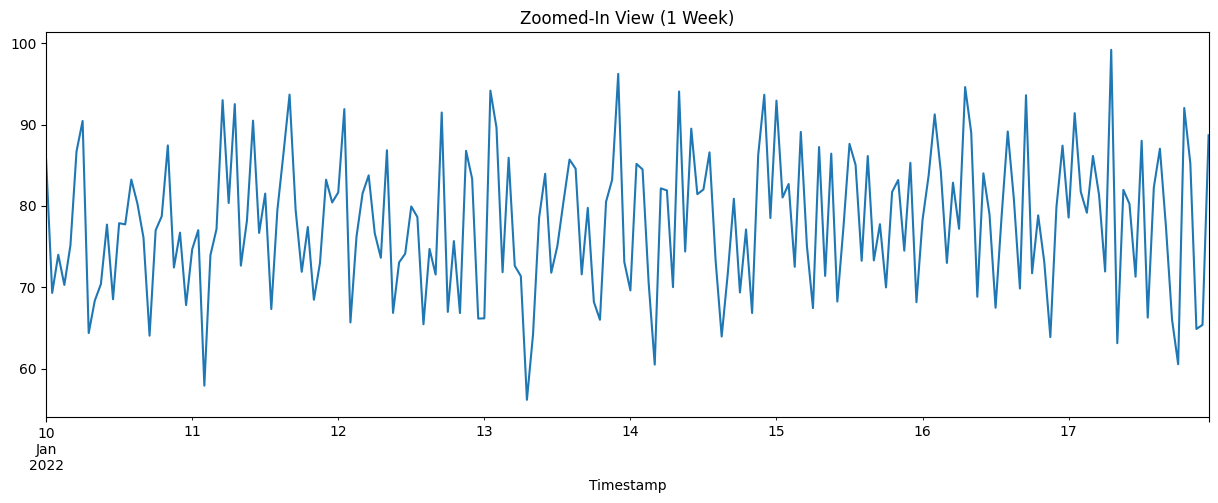

In [6]:
df['2022-01-10':'2022-01-17']['EnergyConsumption'].plot(figsize=(15,5), title='Zoomed-In View (1 Week)')

### **Zoomed-In View of a Single Week**

* **What it shows:** A closer look at day-to-day and hour-by-hour variation.
* **Interpretation:** Usage varies considerably even within the same day. You can probably detect business-hour or occupancy-based peaks.
* **Action:** This helps when engineering features—think about adding **hour-of-day**, **day-of-week**, or **workday/weekend** flags.

### Aggregate by hour of day to spot usage patterns:

<Axes: title={'center': 'Average Energy Use by Hour'}, xlabel='Timestamp'>

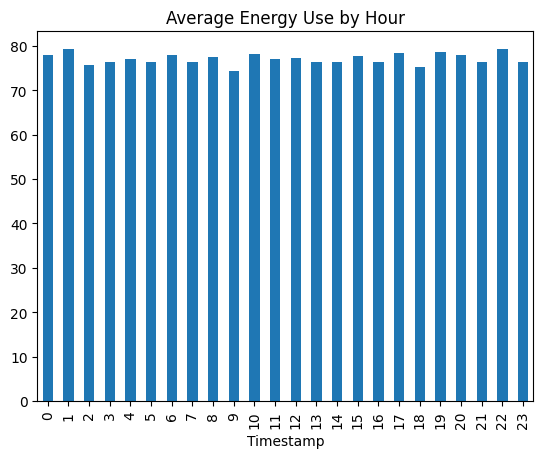

In [7]:
df.groupby(df.index.hour)['EnergyConsumption'].mean().plot(kind='bar', title='Average Energy Use by Hour')

### **Average Energy Use by Hour (Bar Plot)**

* **What it shows:** Mean energy consumption for each hour of the day, aggregated across the dataset.
* **Interpretation:** Slight bumps around early hours and late evening suggest possible HVAC or lighting routines, but overall usage is relatively stable.
* **Action:** If these patterns hold, they may contribute only modestly to predictive power. Still worth encoding time-based features.

### Aggregate by day of week to spot usage patterns:

<Axes: title={'center': 'Average Energy Use by Day of Week'}, xlabel='Timestamp'>

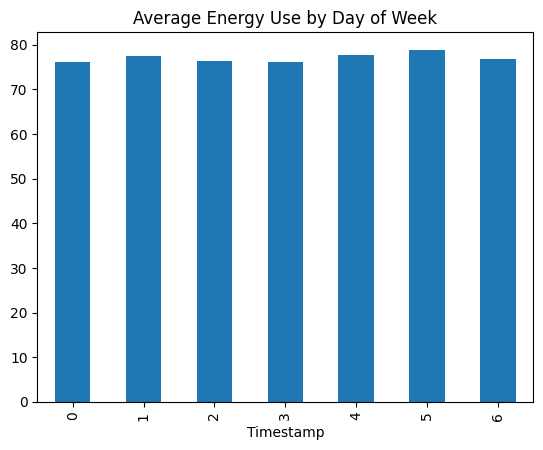

In [8]:
df.groupby(df.index.dayofweek)['EnergyConsumption'].mean().plot(kind='bar', title='Average Energy Use by Day of Week')

### **Average Energy Use by Day of Week (Bar Plot)**

* **What it shows:** Mean energy consumption by weekday (0 = Monday, 6 = Sunday).
* **Interpretation:** Minor variation suggests some weekly rhythm—Fridays and Saturdays may be slightly higher in usage.
* **Action:** This supports including **day-of-week** as a categorical or one-hot encoded feature.

## Seasonal Decomposition (Trend, Seasonality, Residual)

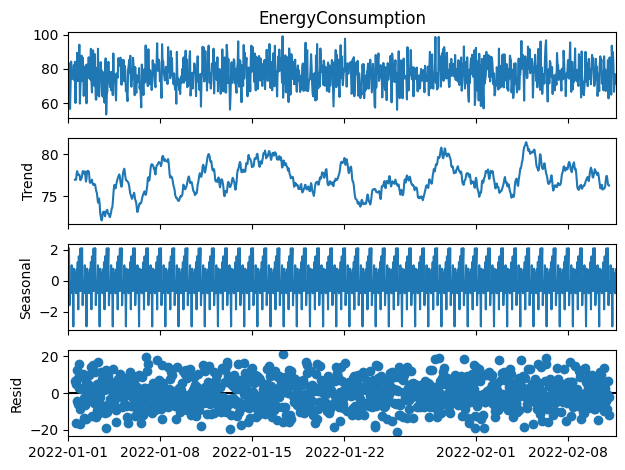

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['EnergyConsumption'], model='additive', period=24)
result.plot();

### 🔷 **Top Panel: Observed (Original Energy Consumption)**

* This is your raw time series, as plotted earlier.
* It includes all variation: **trend + seasonality + noise/residuals**.

---

### 🔷 **Second Panel: Trend**

* This captures the **underlying long-term pattern**.
* Interpretation:

  * There's a smooth, slow-moving rise and fall over time.
  * The trend stays mostly between **73 and 80**, peaking around early February.
  * Suggests changes in base demand or cumulative effects (e.g., gradual occupancy increase or temperature shifts).
* ✅ Useful if your model needs to differentiate between trend and fluctuations (e.g., SARIMA or LSTM with trend input).

---

### 🔷 **Third Panel: Seasonal**

* This isolates **repeating cyclical patterns** based on your specified `period=24` (i.e., daily seasonality for hourly data).
* Interpretation:

  * The daily cycle is **very strong** and consistent, repeating almost identically each day.
  * Indicates **predictable hourly variation** in energy usage — perfect for seasonal modeling.
* ✅ This supports using a **seasonal ARIMA (SARIMA)** model or building engineered cyclical features like sin/cos(hour).

---

### 🔷 **Bottom Panel: Residual**

* What remains after removing trend and seasonality — essentially noise or unexplained variation.
* Interpretation:

  * Appears fairly random, which is a **good sign**.
  * No obvious structure or autocorrelation — suggesting that trend and seasonality captured most of the explainable variance.
* ✅ You’ll still want to validate this with **ACF/PACF plots** and **stationarity tests** to ensure modeling assumptions are met.

---

### ✅ Summary:

* **Daily seasonality is strong and consistent** — supports SARIMA or time-aware ML.
* **Underlying trend exists** — helpful for forecasting longer horizons.
* **Residuals are unstructured** — indicates good decomposition.

## Correlation Matrix of Numeric Features

<Axes: >

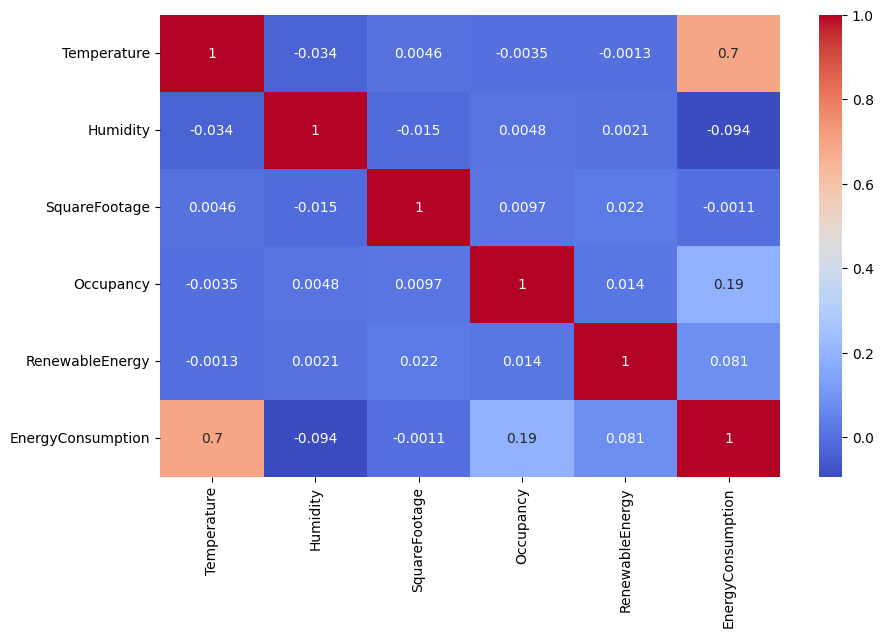

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

### ✅ **Key Insights from the Correlation Matrix**

#### 🔺 Strongest Positive Correlation:

* **Temperature and EnergyConsumption**: **`0.70`**

  * **Interpretation**: As outdoor temperatures rise, energy consumption increases — likely due to greater HVAC cooling needs.
  * ⚠️ This feature is highly predictive and should be retained for modeling.
  * Consider whether the effect is linear or might need a transformation (e.g., squared term).

#### ⚠️ Moderate Positive Correlation:

* **Occupancy and EnergyConsumption**: **`0.19`**

  * **Interpretation**: Higher occupancy leads to higher energy usage — expected in commercial/residential buildings.
  * Could be lagged or interacted with other variables for richer modeling (e.g., occupancy × hour).

#### 🟰 Weak Positive Correlation:

* **RenewableEnergy and EnergyConsumption**: **`0.08`**

  * Slight positive correlation, but it may not be directly interpretable — could be driven by an underlying factor like daylight availability or building usage patterns.

#### 🔻 Weak or No Correlation:

* **Humidity, SquareFootage**: Close to `0`

  * Likely not useful as predictors unless they interact non-linearly.
  * You may still want to retain them initially and let feature importance or model tuning decide.

---

### 🧠 What to Do Next:

1. ✅ **Retain Temperature & Occupancy** — likely to be among top predictors.
2. ✅ **Consider Feature Engineering**:

   * **Interaction Terms**: `Temperature × Occupancy`, `Hour × Occupancy`
   * **Lag Features** for Temperature if its impact is delayed.
3. ❓ **Evaluate RenewableEnergy** carefully — correlation is low, but may still be meaningful in more complex models.
4. ❌ **Consider Dropping or Transforming** Humidity/SquareFootage unless feature importance later proves otherwise.


## Boxplots by Hour and Day

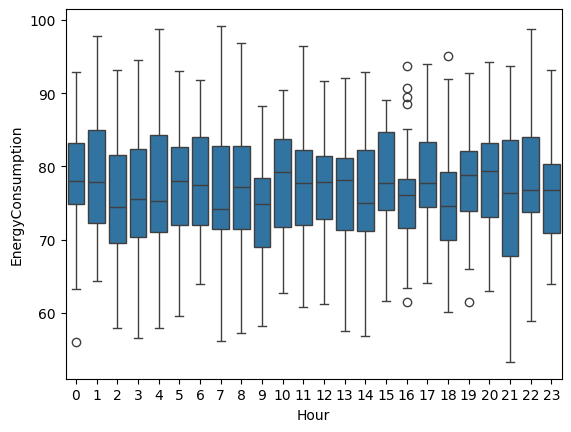

In [11]:
df['Hour'] = df.index.hour
sns.boxplot(x='Hour', y='EnergyConsumption', data=df);

### **Boxplot by Hour (x='Hour', y='EnergyConsumption')**

#### **General Observations**

* Each box represents the distribution of energy usage for a specific hour of the day.
* The line inside the box is the **median**, while the box spans the **interquartile range (IQR)**.
* Whiskers extend to 1.5×IQR, and dots are **outliers**.

---

### **Hourly Insights**

* **Highest medians**: Occur around **1 AM – 3 AM** and again around **10 PM – 12 AM**. Energy use seems to **start high at night**, suggesting **HVAC or base load systems** running overnight.

* **Lowest median usage**: Appears from **11 AM to 5 PM**, which might reflect lower daytime demand or improved daylight efficiency.

* **Widest variability**: Hours **0–6** and **22–23** show **larger IQRs**, meaning wider variation in consumption during late night and early morning.

* **Outliers**: Scattered throughout, especially between **13:00–17:00**, suggesting sporadic energy spikes (e.g., occupancy or appliance-driven).

### Interpretation Takeaways

* There is a **diurnal cycle**: energy is higher overnight and drops during the day, possibly due to cooling/heating cycles or lighting needs.
* These patterns support **hour-of-day** as an important feature.


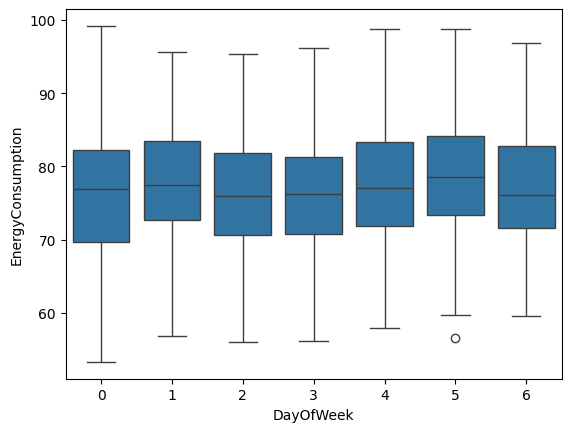

In [12]:
df['DayOfWeek'] = df.index.dayofweek
sns.boxplot(x='DayOfWeek', y='EnergyConsumption', data=df);

### **Boxplot by `DayOfWeek` (0=Monday, 6=Sunday)**

#### **What we observe:**

* **Fairly uniform medians**: The median energy use stays mostly within the 75–80 range across all days.
* **Slightly higher usage mid-to-late week**: Days **4 (Friday)** and **5 (Saturday)** show slightly **higher medians** and **broader IQRs**, indicating greater usage variability.
* **Lower variability early week**: Monday (0) and Tuesday (1) have **narrower interquartile ranges**, suggesting more consistent patterns.
* **Outlier on Saturday (5)**: A low outlier suggests one unusually low-consumption Saturday hour.

---

### Interpretation Takeaways:

* Energy consumption does **not change dramatically** by weekday, but:

  * **Friday and Saturday** may have more fluctuating activity (e.g., events, weekend prep).
  * **Monday–Wednesday** appear more stable, possibly due to predictable weekday routines.
* Consider encoding a **`Weekend` flag** (Saturday/Sunday) if your models show better performance with that binary distinction.

## Encode Categorical Variables

In [13]:
# Binary: map Yes/No to 1/0
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})
# One-hot encode multiclass
df = pd.get_dummies(df, columns=['HVACUsage', 'LightingUsage'], drop_first=True)

## Add Time-Based Features

In [14]:
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

## Create Lag or Rolling Features

In [15]:
df['lag_1'] = df['EnergyConsumption'].shift(1)
df['rolling_mean_24'] = df['EnergyConsumption'].rolling(24).mean()

## ARIMA/SARIMA Readiness Check

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['EnergyConsumption'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
df['diff_1'] = df['EnergyConsumption'].diff().dropna()

ADF Statistic: -31.576934146718365
p-value: 0.0


### **ADF Test (Stationarity Check)**

ADF result:

* **ADF Statistic**: `-31.58`
* **p-value**: `0.0`

> This is **strong evidence of stationarity** (we reject the null hypothesis that a unit root is present).

**NO need to difference** the series at this time for ARIMA — it’s already mean-reverting.

## ACF and PACF Plots

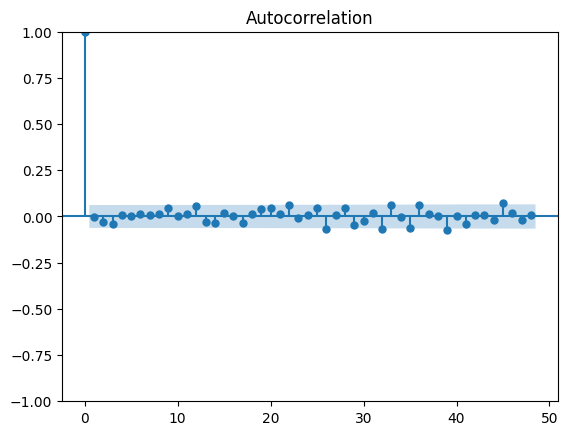

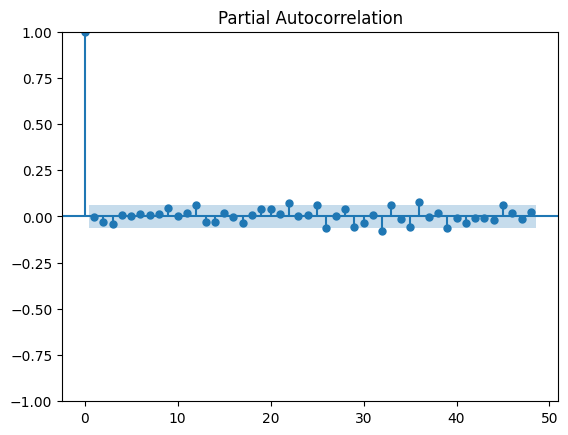

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['EnergyConsumption'].dropna(), lags=48);
plot_pacf(df['EnergyConsumption'].dropna(), lags=48);

### **ACF/PACF**

* **ACF/PACF**: Significant lag at 1, but very low correlation after. No strong autocorrelation.

**Takeaway**: Series is stationary, but **ARIMA/SARIMA** models may not need many lag terms. You’ll likely try **ARIMA(1,0,0)** or SARIMA with 24-period seasonal terms.

## Optional Enhancements

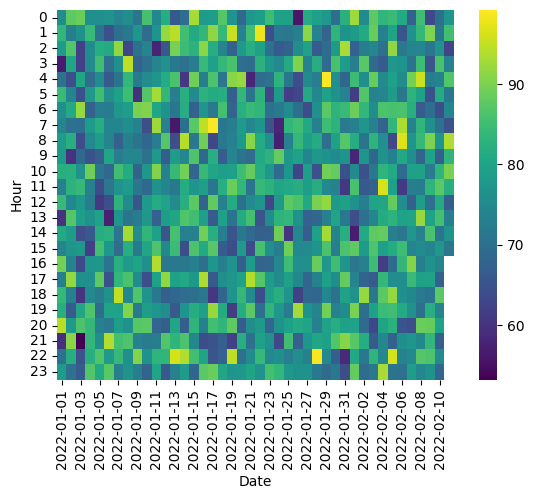

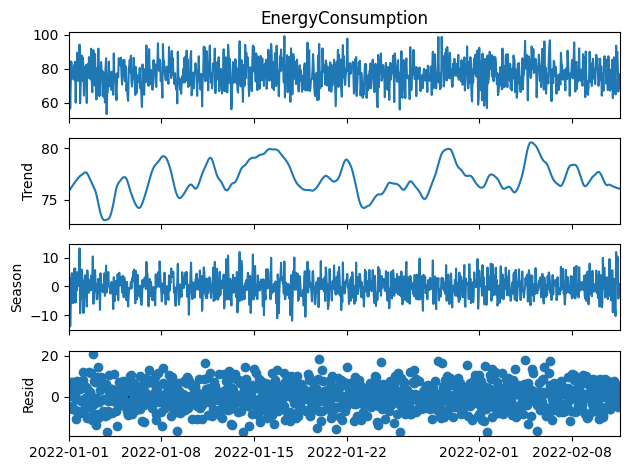

In [18]:
df['Date'] = df.index.date
pivot = df.pivot_table(index='Hour', columns='Date', values='EnergyConsumption')
sns.heatmap(pivot, cmap='viridis')
from statsmodels.tsa.seasonal import STL
stl = STL(df['EnergyConsumption'], period=24)
res = stl.fit(); res.plot();


### **1. Heatmap of Hourly Energy Use by Date**

(First image)

This heatmap shows average **energy consumption by hour (y-axis)** across different **days (x-axis)**:

#### What it reveals:

* **Vertical patterns** could suggest regular daily cycles (e.g., certain hours always consuming more or less).
* **Horizontal patterns** might suggest certain days being consistently high/low across hours.
* **Random scatter** of colors (which we mostly see here) suggests **low day-to-day or hourly seasonality** — the variability is high and not strongly patterned.

#### Takeaway:

There’s no *strongly structured* seasonality by hour or day — consumption varies quite a bit. But there are still *faint hints* of routine, particularly in early or late hours. It may still be worthwhile to investigate calendar features or context-specific lags (like weekends or workdays).

---

### **2. STL Decomposition (Seasonal-Trend-Loess)**

(Second image)

This is a different form of decomposition than `seasonal_decompose()` — STL is more robust and flexible, especially when seasonal components change over time.

#### Breakdown:

* **Top panel (Observed)**: Raw energy data over time.
* **Second panel (Trend)**: A **smoothed curve** showing the underlying trend. Looks like usage gently rises and falls in about week-long cycles — even with noise.
* **Third panel (Seasonal)**: Repeating hourly/short-term patterns captured as “seasonal” structure. Less clean than textbook examples, but consistent with minor cyclical behavior.
* **Bottom panel (Residual)**: What remains after trend and seasonal patterns are removed — basically the unexplained part.

#### Compared to `seasonal_decompose()`:

* STL gives a **smoother, clearer trend** and **more nuanced seasonality**.
* The previous seasonal decomposition used a fixed model (`additive`) and period, which can struggle with noisy data like this.
* STL is likely the better diagnostic choice here.

In [19]:
print (df.columns)

Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
       'RenewableEnergy', 'DayOfWeek', 'Holiday', 'EnergyConsumption', 'Hour',
       'HVACUsage_On', 'LightingUsage_On', 'Month', 'IsWeekend', 'lag_1',
       'rolling_mean_24', 'diff_1', 'Date'],
      dtype='object')


In [20]:
print(df[['HVACUsage_On', 'Occupancy']].dtypes)
print(df[['HVACUsage_On', 'Occupancy']].head())


HVACUsage_On     bool
Occupancy       int64
dtype: object
                     HVACUsage_On  Occupancy
Timestamp                                   
2022-01-01 00:00:00          True          5
2022-01-01 01:00:00          True          1
2022-01-01 02:00:00         False          2
2022-01-01 03:00:00         False          1
2022-01-01 04:00:00          True          9


In [21]:
exog_vars = df[['HVACUsage_On', 'Occupancy']].copy()
exog_vars['HVACUsage_On'] = exog_vars['HVACUsage_On'].astype(int)

In [22]:
print(exog_vars.dtypes)
print(exog_vars.head())

HVACUsage_On    int64
Occupancy       int64
dtype: object
                     HVACUsage_On  Occupancy
Timestamp                                   
2022-01-01 00:00:00             1          5
2022-01-01 01:00:00             1          1
2022-01-01 02:00:00             0          2
2022-01-01 03:00:00             0          1
2022-01-01 04:00:00             1          9


In [23]:
df = df.copy()
df.index.freq = 'h'  # Capital 'H' for hourly data


Naive Forecast:
RMSE: 11.51756117698301
MAE : 9.43022212189126
R²  : -1.000103165217995
------------------------------
Moving Average Forecast:
RMSE: 8.23331885962996
MAE : 6.650585121464826
R²  : -0.02745579404213161
------------------------------
Simple Exp Smoothing Forecast:
RMSE: 8.170649628674271
MAE : 6.583066115496177
R²  : -0.007535265811399627
------------------------------


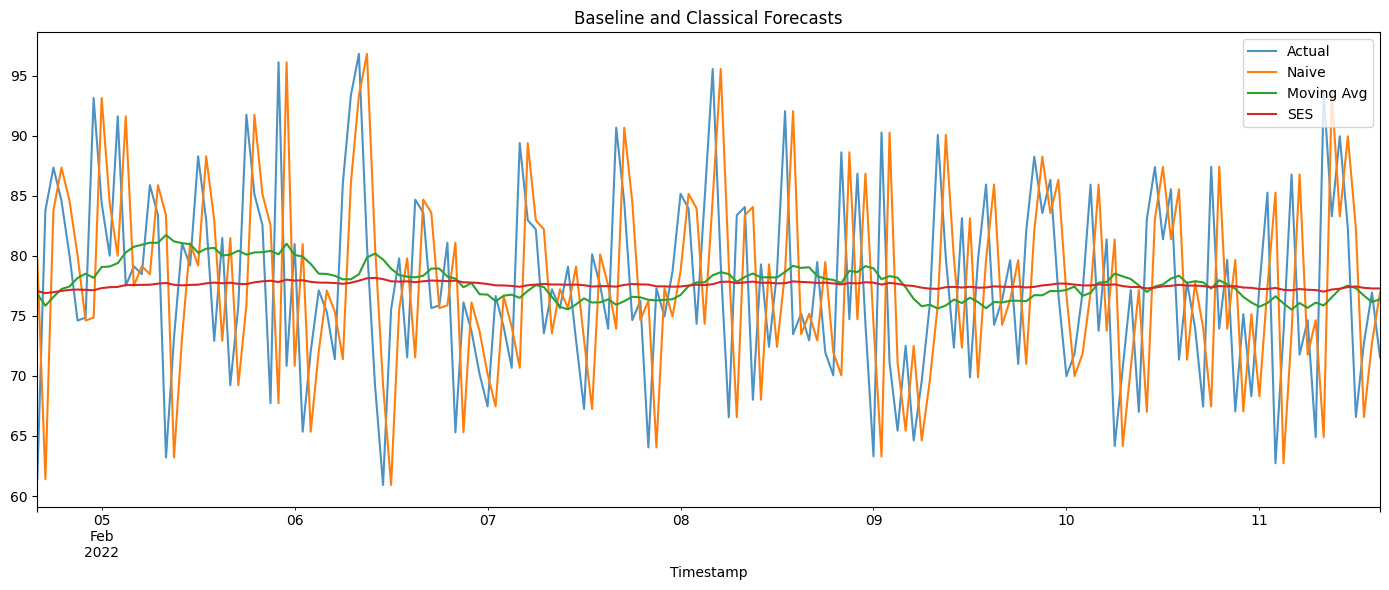

In [24]:

# Phase 3 - Step 1: Baseline & Classical Models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


y = df['EnergyConsumption']

# ---- Naive Forecast ----
naive_forecast = y.shift(1)
df['naive_forecast'] = naive_forecast

# ---- Moving Average Forecast (window=24 for daily avg in hourly data) ----
moving_avg_forecast = y.rolling(window=24).mean().shift(1)
df['moving_avg_forecast'] = moving_avg_forecast

# ---- Simple Exponential Smoothing (SES) ----
ses_model = SimpleExpSmoothing(y, initialization_method="heuristic").fit()
df['ses_forecast'] = ses_model.fittedvalues

# ---- SARIMA (seasonal ARIMA with exogenous variables) ----
# Assumes exogenous vars such as 'hvac_usage', 'occupancy' exist in df
# exog_vars = df[['HVACUsage_On', 'Occupancy']] if {'HVACUsage_On', 'Occupancy'}.issubset(df.columns) else None
# sarima_model = SARIMAX(y, exog=exog_vars, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)).fit(disp=False)
# df['sarima_forecast'] = sarima_model.fittedvalues

# ---- Evaluation Metrics ----
def evaluate_forecast(y_true, y_pred, label):
    mask = ~y_pred.isna()
    print(f"{label} Forecast:")
    print("RMSE:", np.sqrt(mean_squared_error(y_true[mask], y_pred[mask])))
    print("MAE :", mean_absolute_error(y_true[mask], y_pred[mask]))
    print("R²  :", r2_score(y_true[mask], y_pred[mask]))
    print("-" * 30)

evaluate_forecast(y, df['naive_forecast'], "Naive")
evaluate_forecast(y, df['moving_avg_forecast'], "Moving Average")
evaluate_forecast(y, df['ses_forecast'], "Simple Exp Smoothing")
# evaluate_forecast(y, df['sarima_forecast'], "SARIMA")

# ---- Plot Forecasts ----
plt.figure(figsize=(14, 6))
y[-168:].plot(label='Actual', alpha=0.8)
df['naive_forecast'][-168:].plot(label='Naive')
df['moving_avg_forecast'][-168:].plot(label='Moving Avg')
df['ses_forecast'][-168:].plot(label='SES')
# df['sarima_forecast'][-168:].plot(label='SARIMA')
plt.title("Baseline and Classical Forecasts")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# 1. Ensure exog_vars is numeric
exog_vars = df[['HVACUsage_On', 'Occupancy']].copy()
exog_vars = exog_vars.astype(float)

# 2. Ensure y is numeric
y = df['EnergyConsumption'].astype(float)  # replace with actual name if needed

# 3. Align both by dropping rows with NaNs (just in case)
df_model = pd.concat([y, exog_vars], axis=1).dropna()
y_clean = df_model.iloc[:, 0]
exog_clean = df_model.iloc[:, 1:]

# 4. Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(
    y_clean,
    exog=exog_clean,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24)
).fit(disp=False)

# 5. Predict using aligned exogenous variables
df['sarima_forecast'] = sarima_model.predict(
    start=y_clean.index[0],
    end=y_clean.index[-1],
    exog=exog_clean
)


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMAX model
sarima_model = SARIMAX(
    y,
    exog=exog_vars,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24)
).fit(disp=False)

# Predict using the model
df['sarima_forecast'] = sarima_model.predict(start=y.index[0], end=y.index[-1], exog=exog_vars)


SARIMA Forecast:
RMSE: 8.573505565146364
MAE : 6.686102530059967
R²  : -0.10933815169607208
------------------------------


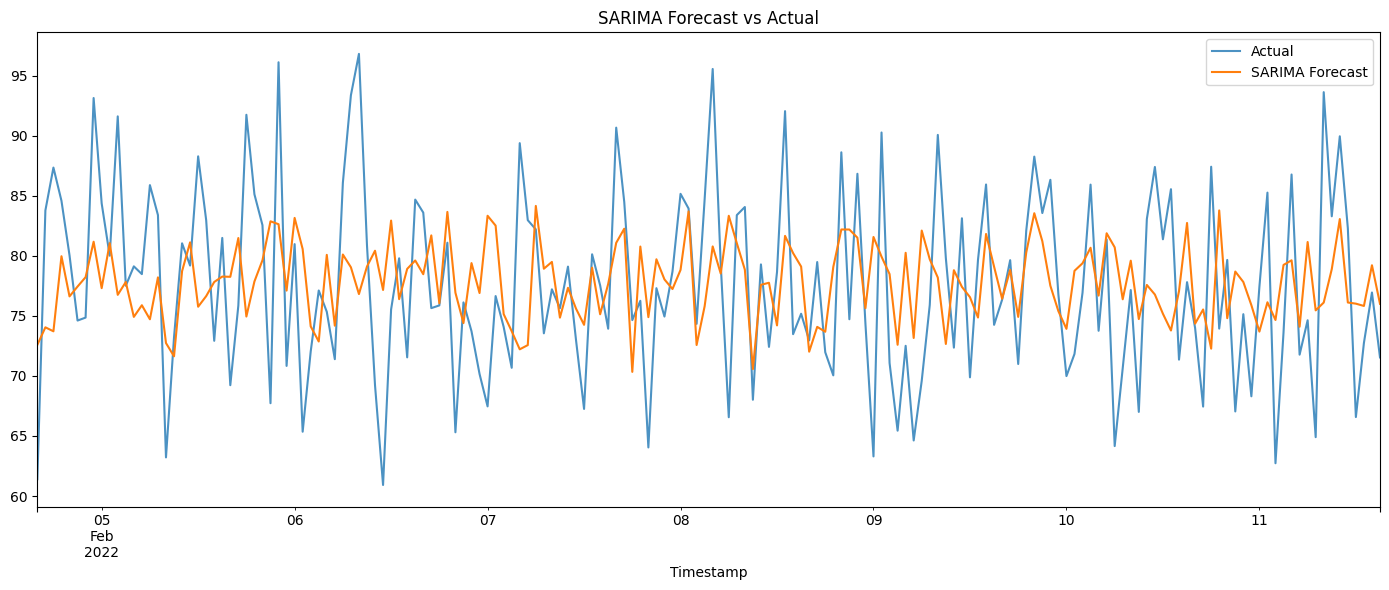

In [27]:
evaluate_forecast(y, df['sarima_forecast'], "SARIMA")

plt.figure(figsize=(14, 6))
y[-168:].plot(label='Actual', alpha=0.8)
df['sarima_forecast'][-168:].plot(label='SARIMA Forecast')
plt.title("SARIMA Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
from pmdarima import auto_arima

auto_model = auto_arima(
    y_clean,
    exogenous=exog_clean,
    seasonal=True,
    m=24,
    trace=True,
    suppress_warnings=True
)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject